In [1]:
import time
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.metrics import classification_report, accuracy_score
from subprocess import check_call
from sklearn.tree import export_graphviz
import operator
from dtreeviz.trees import *
from sklearn.datasets import load_iris
# from IPython import display

import sys
sys.path.append('..')

from Libraries.Utils.Global_Utils import *
from Libraries.SampleRemoval import *
from Libraries.ClusterMaster import *
from Libraries.DataframeTypeHolder import *

%matplotlib inline

In [2]:
def replace_df_vals(passed_df,replace_dict):
    """
        Uses a hash map to decode dataframe data
    """

    def replace_vals_col(data, decoder):
        return decoder[data]

    df = copy.deepcopy(passed_df)
    for col in df.columns:
        if col in replace_dict.keys():
            df[col] = np.vectorize(replace_vals_col)(
                df[col], replace_dict[col])

    return df

# Returns encoded df and label encoded map
def encode_df(df, objt_cols):

    df = copy.deepcopy(df)
    # ---
    le_map = defaultdict(LabelEncoder)

    # Encoding the variable
    fit = df[objt_cols].apply(lambda x: le_map[x.name].fit_transform(x))

    # Inverse the encoded
    fit.apply(lambda x: le_map[x.name].inverse_transform(x))

    # Using the dictionary to label future data
    df[objt_cols] = df[objt_cols].apply(lambda x: le_map[x.name].transform(x))

    return df, le_map

def decode_df(df,le_map):
    
    df = copy.deepcopy(df)
    decode_cols = list(le_map.keys())
    df[decode_cols] = df[decode_cols].apply(lambda x: le_map[x.name].inverse_transform(x))
    
    return df


def print_encode_map(le):

    print("\nLabel mapping:\n")
    for i, item in enumerate(le.classes_):
        print("\t", item, '-->', i)

    # Draw a line
    print("-"*30, "\n")

In [3]:
iris = load_iris()

In [4]:
iris_df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                       columns=iris['feature_names'] + ['species'])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [5]:
# http://archive.ics.uci.edu/ml/datasets/Heart+Disease
replace_dict = dict()

replace_dict["species"] = {0:"Setosa",
                           1:"Versicolor",
                           2:"Virginica"}

iris_df = replace_df_vals(iris_df,replace_dict)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [6]:
df_features = DataframeTypeHolder(iris_df)
df_features.display_all()

Categorical Features: {'species'}

Bool Features: set()

------------------------------------------------------------------------------------------
Numerical Features: {'petal length (cm)', 'sepal width (cm)', 'petal width (cm)', 'sepal length (cm)'}

Integer Features: set()

Float Features: {'petal length (cm)', 'sepal width (cm)', 'petal width (cm)', 'sepal length (cm)'}



In [7]:
iris_df, le_map = encode_df(iris_df, df_features.get_categorical_features())
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [8]:
iris_df.values.shape

(150, 5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
sepal length (cm),1,-0.11757,0.871754,0.817941,0.782561
sepal width (cm),-0.11757,1,-0.42844,-0.366126,-0.426658
petal length (cm),0.871754,-0.42844,1,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1,0.956547
species,0.782561,-0.426658,0.949035,0.956547,1


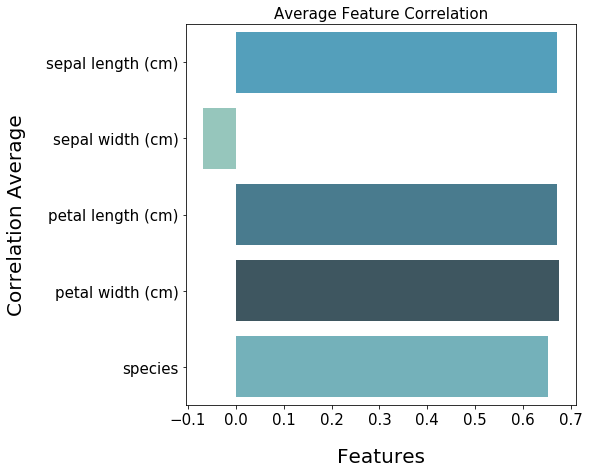

In [9]:
corr_metrics = iris_df.corr()
display(corr_metrics.style.background_gradient())

# Get the correlation means of each feature
corr_feature_means = []
for feature_name in list(corr_metrics.columns):
    corr_feature_means.append(corr_metrics[feature_name].mean())

# Graph rank
display_rank_graph(feature_names=list(corr_metrics.columns),
                   metric=corr_feature_means,
                   title="Average Feature Correlation",
                   y_title="Correlation Average",
                   x_title="Features")

In [10]:
sample_target_dict = dict()
sample_target_dict["species"] = 2


Inspecting scaled results!


,Mean,Standard Dev
sepal length (cm),2.802203e-15,1.0
sepal width (cm),-6.136758e-16,1.0
petal length (cm),-1.010303e-15,1.0
petal width (cm),-9.303669e-16,1.0


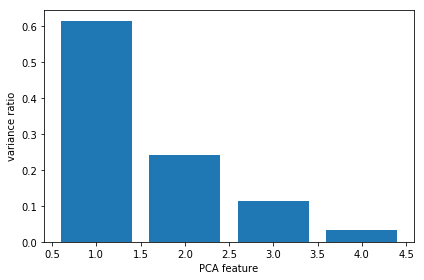

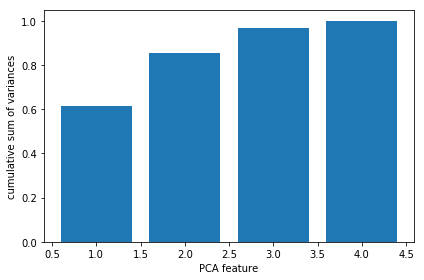


Inspecting applied pca results!


,Mean,Standard Dev
PCA_Feature_1,3.552714e-17,1.566760
PCA_Feature_2,1.776357e-17,0.982198
PCA_Feature_3,-4.884981e-17,0.672512
PCA_Feature_4,-1.221245e-17,0.358160


After applying pca with a cutoff percentage of 0.94% for the cumulative index. Using features 1 to 3
Old shape (50, 4)
New shape (50, 3)

Inspecting re-applied scaled results!


,Mean,Standard Dev
PCA_Feature_1,8.881784e-18,1.0
PCA_Feature_2,3.330669e-18,1.0
PCA_Feature_3,4.440892e-18,1.0


In [11]:
sample_remover = SampleRemoval(df=iris_df,
                               sample_target_dict=sample_target_dict,
                               columns_to_drop=list(sample_target_dict.keys()),
                               pca_perc=.94)

The total time required is: 0:00:00.015925
Scaled size is now 49
Scaled size is now 48
Scaled size is now 47
Scaled size is now 46
Scaled size is now 45
Scaled size is now 44
Scaled size is now 43
Scaled size is now 42
Scaled size is now 41
Scaled size is now 40
Scaled size is now 39
Scaled size is now 38
Scaled size is now 37
Scaled size is now 36
Scaled size is now 35
Scaled size is now 34
Scaled size is now 33
Scaled size is now 32
Scaled size is now 31
Scaled size is now 30
Scaled size is now 29
Scaled size is now 28
Scaled size is now 27
Scaled size is now 26
Scaled size is now 25
Scaled size is now 24
Scaled size is now 23
Scaled size is now 22
Scaled size is now 21
Scaled size is now 20


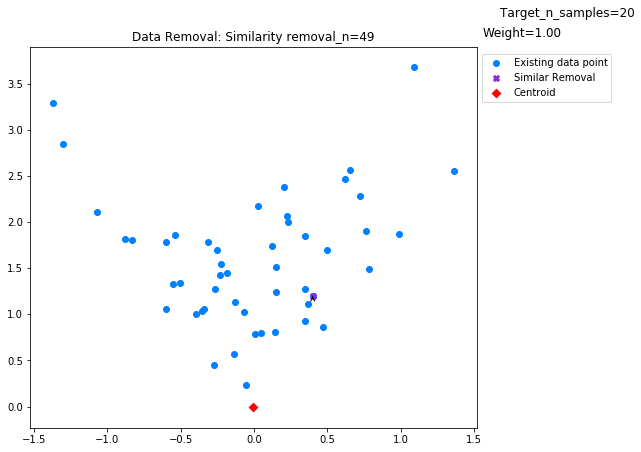

[101,
 127,
 143,
 100,
 138,
 115,
 137,
 132,
 116,
 145,
 139,
 126,
 148,
 104,
 141,
 107,
 142,
 144,
 146,
 147,
 123,
 102,
 140,
 120,
 110,
 128,
 129,
 122,
 105,
 111]

In [12]:
sample_remover.remove_similar(new_sample_amount=20,
                            annotate=True,
                            show_gif=True)

In [13]:
shelf = shelve.open("Shelves/Removal_df_indexes")
print(shelf["Shelves/Removal_df_indexes".split("/")[-1]])
shelf.close()

[118]


In [14]:
scaled = sample_remover.get_scaled_data()

### Expermenting

In [15]:
from scipy.spatial import distance
def shortest_dist_with_target(target_dp_index):
    
    distances = np.zeros(tmp_len - (target_dp_index + 1))
    for index,dp_index in enumerate(index_array[target_dp_index + 1:]):
        distances[index] = distance.euclidean(scaled[target_dp_index],
                                              scaled[dp_index])
    shortest_dp_index = np.argmin(distances)
    
    return {target_dp_index:(index_array[target_dp_index + 1:][shortest_dp_index],distances[shortest_dp_index])}

In [16]:
# 
def shortest_dist_relationship():
    
    all_shortest_distances = dict()
    for target_dp_index in range(0,index_array[-1]):
        
        all_shortest_distances = {**all_shortest_distances,
                                  **shortest_dist_with_target(target_dp_index)}
        
        
    print(all_shortest_distances)

    return min(all_shortest_distances.items(), key=lambda x: x[1][1])

In [17]:
shortest_dist_relationship()

NameError: name 'index_array' is not defined

In [ ]:
x = np.linspace(-1, -1.5, 200)
y = np.exp(x)

plt.figure()
plt.plot(x, y)
plt.xlabel('$x$')
plt.ylabel('$\exp(x)$')

plt.figure()
plt.plot(x, -np.exp(-x))
plt.xlabel('$x$')
plt.ylabel('$-\exp(-x)$')

plt.show()

In [ ]:
dist_centroid = 1.1

In [ ]:
a = [1.64021086, 1.01262395, 1.42766285, 1.16884993, 1.04884904, 2.03399206, 0.94079837]

In [ ]:
centroid = np.mean(scaled, axis=0)

In [ ]:
np.exp(np.linspace(-1, -1.5, 100))

In [ ]:
a = np.random.rand(700)
b = np.random.rand(700)

In [ ]:
%timeit  distance.euclidean(a,b)

In [ ]:
10.4

In [ ]:
golden = (1 + 5 ** 0.5) / 2

In [ ]:
from numpy import linspace
from math import cos, sin, pi

In [ ]:
x = []
y = []
for theta in linspace(0,5*pi):
    r = ((theta)**2)
    x.append(r*cos(theta))
    y.append(r*sin(theta))

plt.plot(x,y)  
plt.show()

In [ ]:
len(x)

In [ ]:
index_array[:-1]

In [ ]:
for dp_index_key in range(40,50-1):
    print(dp_index_key)

In [ ]:
for dp_index_key in range(1-1,-1,-1):
    print(dp_index_key)

In [ ]:
total = 0
for i in range(0,48):
    total += i
print(total)
    

In [ ]:
import time
import random
from multiprocessing import Pool
import tqdm

pbar = tqdm.tqdm(total=100)

def myfunc(a):
    time.sleep(random.random())
    pbar.update(1)
    return a ** 2

pool = Pool(2)
pool.map(myfunc, range(100))
pool.close()
pool.join()
pbar.close()

In [ ]:
a = np.arange(10)
np.random.shuffle(a,random_state=2)
a

In [ ]:
np.empty([2, 2], dtype=np.array([]))